# Introdução

Nos dados que usamos na primeira parte do projeto os experimentos se mostraram frustrantes, dado que as amostras eram muito homogêneas para quaisquer variáveis que nos interessavam. Creditamos boa parte desse problema ao TRI (Teoria de Resposta ao Item do ENEM) que não distribui as notas de forma diretamente proporcional aos acertos. 
Resolvemos então trazer um novo dataset para essa segunda parte, esta que depende muito da segmentação dos grupos de dados. O dataset que utilazaremos apresenta dados de humidade, velocidade do vento, entre outras features para previsão de chuva. Utilizaremos mais especificamente os dados de umidade às 9am e 3pm com o objetivo de prever a chuva do dia corrente.

In [3]:
import pandas as pd
std = pd.read_csv("https://raw.githubusercontent.com/dariogsv/Ciencia-de-dados/main/weatherAUS.csv")
std.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
std = std.dropna()
std.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

In [5]:
std.RainToday = std.RainToday.astype('category').cat.codes
std.corr()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
MinTemp,1.000000,0.749687,0.110800,0.506764,0.076087,0.118054,0.108522,0.137273,-0.174991,0.070827,-0.475661,-0.495577,0.106177,0.042173,0.906295,0.727222,0.048953
MaxTemp,0.749687,1.000000,-0.069981,0.650964,0.463913,0.035531,-0.008171,0.012266,-0.495781,-0.448116,-0.350980,-0.451691,-0.263634,-0.257752,0.893387,0.984841,-0.221810
Rainfall,0.110800,-0.069981,1.000000,-0.077239,-0.246379,0.106308,0.050584,0.044112,0.263625,0.277625,-0.180606,-0.137302,0.217169,0.191433,0.013713,-0.074627,0.550515
Evaporation,0.506764,0.650964,-0.077239,1.000000,0.369250,0.209566,0.193154,0.124345,-0.554232,-0.422436,-0.297319,-0.325954,-0.199809,-0.202366,0.593122,0.630727,-0.218079
Sunshine,0.076087,0.463913,-0.246379,0.369250,1.000000,-0.052422,-0.013842,0.029200,-0.500343,-0.629299,0.043330,-0.020632,-0.677939,-0.702022,0.289038,0.486129,-0.328904
WindGustSpeed,0.118054,0.035531,0.106308,0.209566,-0.052422,1.000000,0.608852,0.685236,-0.193410,-0.042653,-0.430363,-0.383683,0.088129,0.131590,0.085520,-0.000382,0.146276
WindSpeed9am,0.108522,-0.008171,0.050584,0.193154,-0.013842,0.608852,1.000000,0.502226,-0.236795,-0.058449,-0.201518,-0.155484,0.034908,0.062507,0.053749,-0.018357,0.083125
WindSpeed3pm,0.137273,0.012266,0.044112,0.124345,0.029200,0.685236,0.502226,1.000000,-0.100626,0.031843,-0.293155,-0.252095,0.068224,0.041475,0.114043,-0.009436,0.085627
Humidity9am,-0.174991,-0.495781,0.263625,-0.554232,-0.500343,-0.193410,-0.236795,-0.100626,1.000000,0.685697,0.114575,0.172972,0.438962,0.348707,-0.423598,-0.487758,0.379451
Humidity3pm,0.070827,-0.448116,0.277625,-0.422436,-0.629299,-0.042653,-0.058449,0.031843,0.685697,1.000000,-0.063454,0.024109,0.509223,0.510996,-0.151614,-0.497245,0.385440


Podemos perceber que os 3 fatores de maior correlação com a ocorrência de chuva no dia são Rainfall (previsão de chuva em mm), Humidity3pm e Humidity9am, nessa ordem. Usaremos os métodos do sklearn para produzir um modelo de previsão baseado na humidade do dia.

In [ ]:
!pip install mlflow
!pip install optuna
!pip install auto-sklearn
!pip install scipy==1.7.1

In [6]:
#Importando bibliotecas e configurando o logging entre elas
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score
import optuna
import logging
from sklearn.metrics import confusion_matrix

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

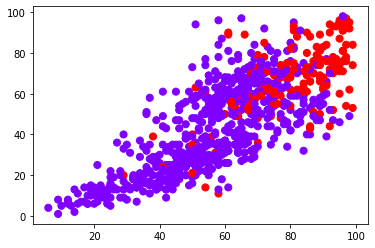

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
# In the first step we will split the data in training and remaining dataset
X = (std[["Humidity9am", "Humidity3pm"]])[:1000].to_numpy()
y = std.RainToday[:1000].to_numpy()
Xtrain, Xrem, ytrain, yrem = train_test_split(X,y, train_size=0.8)
Xvalid, Xtest, yvalid, ytest = train_test_split(Xrem, yrem, train_size=0.5, random_state=34)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, s=50, cmap='rainbow')

In [15]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

def RFObjective(trial):
  with mlflow.start_run(run_name="RandomForestClassifier"):
    #Especificando o range dos hiperparâmetros
    max_depth = trial.suggest_int('max_depth', 1, 100)
    n_estimators = trial.suggest_int('n_estimators', 1, 100)

    #Construindo o modelo
    model = RandomForestClassifier(max_depth=max_depth, random_state=112, n_estimators=n_estimators)
    model.fit(Xtrain, ytrain)
    
    #Validando o modelo
    ypred_valid = model.predict(Xvalid)
    ypred_train = model.predict(Xtrain)
    acc_valid = accuracy_score(yvalid, ypred_valid)
    acc_train = accuracy_score(ytrain, ypred_train)

    print("ACC TRAINING:" + str(acc_train))
    print("ACC VALID:" + str(acc_valid))
    print("Random Forest model (max_depth=%f, n_estimators=%f):" % (max_depth, n_estimators))

    mlflow.log_param('max_depth', max_depth)
    mlflow.log_param('n_estimators', n_estimators)
    mlflow.log_metric('acc_valid', acc_valid)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "model", registered_model_name="RandomForestClassifier")
    else:
        mlflow.sklearn.log_model(model, "model")
    
    # output: evaluation score
    return acc_valid

study_randomforest = optuna.create_study(direction='maximize')
study_randomforest.optimize(RFObjective, n_trials=40)

[I 2021-08-17 01:28:02,764] A new study created in memory with name: no-name-b1de0a9f-0cc6-4c1d-9d47-2a54087f8af1
[I 2021-08-17 01:28:02,927] Trial 0 finished with value: 0.83 and parameters: {'max_depth': 97, 'n_estimators': 51}. Best is trial 0 with value: 0.83.
[I 2021-08-17 01:28:02,987] Trial 1 finished with value: 0.87 and parameters: {'max_depth': 3, 'n_estimators': 13}. Best is trial 1 with value: 0.87.


ACC TRAINING:0.9825
ACC VALID:0.83
Random Forest model (max_depth=97.000000, n_estimators=51.000000):
ACC TRAINING:0.885
ACC VALID:0.87
Random Forest model (max_depth=3.000000, n_estimators=13.000000):


[I 2021-08-17 01:28:03,181] Trial 2 finished with value: 0.83 and parameters: {'max_depth': 51, 'n_estimators': 64}. Best is trial 1 with value: 0.87.


ACC TRAINING:0.9825
ACC VALID:0.83
Random Forest model (max_depth=51.000000, n_estimators=64.000000):


[I 2021-08-17 01:28:03,461] Trial 3 finished with value: 0.83 and parameters: {'max_depth': 79, 'n_estimators': 97}. Best is trial 1 with value: 0.87.


ACC TRAINING:0.9825
ACC VALID:0.83
Random Forest model (max_depth=79.000000, n_estimators=97.000000):


[I 2021-08-17 01:28:03,733] Trial 4 finished with value: 0.83 and parameters: {'max_depth': 25, 'n_estimators': 92}. Best is trial 1 with value: 0.87.
[I 2021-08-17 01:28:03,780] Trial 5 finished with value: 0.81 and parameters: {'max_depth': 90, 'n_estimators': 5}. Best is trial 1 with value: 0.87.


ACC TRAINING:0.9825
ACC VALID:0.83
Random Forest model (max_depth=25.000000, n_estimators=92.000000):
ACC TRAINING:0.95875
ACC VALID:0.81
Random Forest model (max_depth=90.000000, n_estimators=5.000000):


[I 2021-08-17 01:28:03,998] Trial 6 finished with value: 0.83 and parameters: {'max_depth': 36, 'n_estimators': 71}. Best is trial 1 with value: 0.87.
[I 2021-08-17 01:28:04,048] Trial 7 finished with value: 0.81 and parameters: {'max_depth': 69, 'n_estimators': 5}. Best is trial 1 with value: 0.87.


ACC TRAINING:0.9825
ACC VALID:0.83
Random Forest model (max_depth=36.000000, n_estimators=71.000000):
ACC TRAINING:0.95875
ACC VALID:0.81
Random Forest model (max_depth=69.000000, n_estimators=5.000000):


[I 2021-08-17 01:28:04,286] Trial 8 finished with value: 0.83 and parameters: {'max_depth': 58, 'n_estimators': 82}. Best is trial 1 with value: 0.87.
[I 2021-08-17 01:28:04,336] Trial 9 finished with value: 0.84 and parameters: {'max_depth': 98, 'n_estimators': 8}. Best is trial 1 with value: 0.87.


ACC TRAINING:0.9825
ACC VALID:0.83
Random Forest model (max_depth=58.000000, n_estimators=82.000000):
ACC TRAINING:0.96375
ACC VALID:0.84
Random Forest model (max_depth=98.000000, n_estimators=8.000000):
ACC TRAINING:0.8975
ACC VALID:0.87
Random Forest model (max_depth=5.000000, n_estimators=27.000000):


[I 2021-08-17 01:28:04,443] Trial 10 finished with value: 0.87 and parameters: {'max_depth': 5, 'n_estimators': 27}. Best is trial 1 with value: 0.87.
[I 2021-08-17 01:28:04,562] Trial 11 finished with value: 0.89 and parameters: {'max_depth': 2, 'n_estimators': 31}. Best is trial 11 with value: 0.89.
[I 2021-08-17 01:28:04,675] Trial 12 finished with value: 0.89 and parameters: {'max_depth': 2, 'n_estimators': 29}. Best is trial 11 with value: 0.89.


ACC TRAINING:0.8675
ACC VALID:0.89
Random Forest model (max_depth=2.000000, n_estimators=31.000000):
ACC TRAINING:0.86875
ACC VALID:0.89
Random Forest model (max_depth=2.000000, n_estimators=29.000000):


[I 2021-08-17 01:28:04,807] Trial 13 finished with value: 0.83 and parameters: {'max_depth': 20, 'n_estimators': 33}. Best is trial 11 with value: 0.89.
[I 2021-08-17 01:28:04,942] Trial 14 finished with value: 0.83 and parameters: {'max_depth': 18, 'n_estimators': 33}. Best is trial 11 with value: 0.89.


ACC TRAINING:0.9825
ACC VALID:0.83
Random Forest model (max_depth=20.000000, n_estimators=33.000000):
ACC TRAINING:0.9825
ACC VALID:0.83
Random Forest model (max_depth=18.000000, n_estimators=33.000000):


[I 2021-08-17 01:28:05,121] Trial 15 finished with value: 0.83 and parameters: {'max_depth': 36, 'n_estimators': 48}. Best is trial 11 with value: 0.89.
[I 2021-08-17 01:28:05,217] Trial 16 finished with value: 0.89 and parameters: {'max_depth': 2, 'n_estimators': 23}. Best is trial 11 with value: 0.89.


ACC TRAINING:0.9825
ACC VALID:0.83
Random Forest model (max_depth=36.000000, n_estimators=48.000000):
ACC TRAINING:0.8775
ACC VALID:0.89
Random Forest model (max_depth=2.000000, n_estimators=23.000000):


[I 2021-08-17 01:28:05,319] Trial 17 finished with value: 0.85 and parameters: {'max_depth': 35, 'n_estimators': 21}. Best is trial 11 with value: 0.89.
[I 2021-08-17 01:28:05,478] Trial 18 finished with value: 0.84 and parameters: {'max_depth': 13, 'n_estimators': 44}. Best is trial 11 with value: 0.89.


ACC TRAINING:0.9775
ACC VALID:0.85
Random Forest model (max_depth=35.000000, n_estimators=21.000000):
ACC TRAINING:0.98
ACC VALID:0.84
Random Forest model (max_depth=13.000000, n_estimators=44.000000):


[I 2021-08-17 01:28:05,592] Trial 19 finished with value: 0.85 and parameters: {'max_depth': 30, 'n_estimators': 19}. Best is trial 11 with value: 0.89.
[I 2021-08-17 01:28:05,748] Trial 20 finished with value: 0.84 and parameters: {'max_depth': 11, 'n_estimators': 42}. Best is trial 11 with value: 0.89.


ACC TRAINING:0.9775
ACC VALID:0.85
Random Forest model (max_depth=30.000000, n_estimators=19.000000):
ACC TRAINING:0.9775
ACC VALID:0.84
Random Forest model (max_depth=11.000000, n_estimators=42.000000):


[I 2021-08-17 01:28:05,869] Trial 21 finished with value: 0.88 and parameters: {'max_depth': 1, 'n_estimators': 33}. Best is trial 11 with value: 0.89.
[I 2021-08-17 01:28:05,969] Trial 22 finished with value: 0.85 and parameters: {'max_depth': 13, 'n_estimators': 21}. Best is trial 11 with value: 0.89.


ACC TRAINING:0.86625
ACC VALID:0.88
Random Forest model (max_depth=1.000000, n_estimators=33.000000):
ACC TRAINING:0.9775
ACC VALID:0.85
Random Forest model (max_depth=13.000000, n_estimators=21.000000):


[I 2021-08-17 01:28:06,102] Trial 23 finished with value: 0.88 and parameters: {'max_depth': 1, 'n_estimators': 38}. Best is trial 11 with value: 0.89.


ACC TRAINING:0.86375
ACC VALID:0.88
Random Forest model (max_depth=1.000000, n_estimators=38.000000):
ACC TRAINING:0.975
ACC VALID:0.84
Random Forest model (max_depth=11.000000, n_estimators=57.000000):


[I 2021-08-17 01:28:06,304] Trial 24 finished with value: 0.84 and parameters: {'max_depth': 11, 'n_estimators': 57}. Best is trial 11 with value: 0.89.
[I 2021-08-17 01:28:06,410] Trial 25 finished with value: 0.84 and parameters: {'max_depth': 25, 'n_estimators': 26}. Best is trial 11 with value: 0.89.
[I 2021-08-17 01:28:06,485] Trial 26 finished with value: 0.84 and parameters: {'max_depth': 42, 'n_estimators': 13}. Best is trial 11 with value: 0.89.


ACC TRAINING:0.98125
ACC VALID:0.84
Random Forest model (max_depth=25.000000, n_estimators=26.000000):
ACC TRAINING:0.975
ACC VALID:0.84
Random Forest model (max_depth=42.000000, n_estimators=13.000000):
ACC TRAINING:0.92125
ACC VALID:0.87
Random Forest model (max_depth=8.000000, n_estimators=27.000000):


[I 2021-08-17 01:28:06,606] Trial 27 finished with value: 0.87 and parameters: {'max_depth': 8, 'n_estimators': 27}. Best is trial 11 with value: 0.89.
[I 2021-08-17 01:28:06,798] Trial 28 finished with value: 0.83 and parameters: {'max_depth': 20, 'n_estimators': 55}. Best is trial 11 with value: 0.89.
[I 2021-08-17 01:28:06,936] Trial 29 finished with value: 0.83 and parameters: {'max_depth': 46, 'n_estimators': 38}. Best is trial 11 with value: 0.89.


ACC TRAINING:0.9825
ACC VALID:0.83
Random Forest model (max_depth=20.000000, n_estimators=55.000000):
ACC TRAINING:0.9825
ACC VALID:0.83
Random Forest model (max_depth=46.000000, n_estimators=38.000000):


[I 2021-08-17 01:28:07,025] Trial 30 finished with value: 0.83 and parameters: {'max_depth': 18, 'n_estimators': 14}. Best is trial 11 with value: 0.89.
[I 2021-08-17 01:28:07,148] Trial 31 finished with value: 0.89 and parameters: {'max_depth': 2, 'n_estimators': 33}. Best is trial 11 with value: 0.89.


ACC TRAINING:0.97
ACC VALID:0.83
Random Forest model (max_depth=18.000000, n_estimators=14.000000):
ACC TRAINING:0.87375
ACC VALID:0.89
Random Forest model (max_depth=2.000000, n_estimators=33.000000):


[I 2021-08-17 01:28:07,277] Trial 32 finished with value: 0.88 and parameters: {'max_depth': 7, 'n_estimators': 31}. Best is trial 11 with value: 0.89.
[I 2021-08-17 01:28:07,417] Trial 33 finished with value: 0.89 and parameters: {'max_depth': 2, 'n_estimators': 41}. Best is trial 11 with value: 0.89.


ACC TRAINING:0.91375
ACC VALID:0.88
Random Forest model (max_depth=7.000000, n_estimators=31.000000):
ACC TRAINING:0.87625
ACC VALID:0.89
Random Forest model (max_depth=2.000000, n_estimators=41.000000):


[I 2021-08-17 01:28:07,593] Trial 34 finished with value: 0.83 and parameters: {'max_depth': 15, 'n_estimators': 48}. Best is trial 11 with value: 0.89.
[I 2021-08-17 01:28:07,736] Trial 35 finished with value: 0.83 and parameters: {'max_depth': 25, 'n_estimators': 38}. Best is trial 11 with value: 0.89.


ACC TRAINING:0.9825
ACC VALID:0.83
Random Forest model (max_depth=15.000000, n_estimators=48.000000):
ACC TRAINING:0.9825
ACC VALID:0.83
Random Forest model (max_depth=25.000000, n_estimators=38.000000):


[I 2021-08-17 01:28:07,940] Trial 36 finished with value: 0.88 and parameters: {'max_depth': 7, 'n_estimators': 64}. Best is trial 11 with value: 0.89.
[I 2021-08-17 01:28:07,989] Trial 37 finished with value: 0.85 and parameters: {'max_depth': 7, 'n_estimators': 1}. Best is trial 11 with value: 0.89.
[I 2021-08-17 01:28:08,086] Trial 38 finished with value: 0.83 and parameters: {'max_depth': 80, 'n_estimators': 16}. Best is trial 11 with value: 0.89.


ACC TRAINING:0.9125
ACC VALID:0.88
Random Forest model (max_depth=7.000000, n_estimators=64.000000):
ACC TRAINING:0.895
ACC VALID:0.85
Random Forest model (max_depth=7.000000, n_estimators=1.000000):
ACC TRAINING:0.97125
ACC VALID:0.83
Random Forest model (max_depth=80.000000, n_estimators=16.000000):


[I 2021-08-17 01:28:08,282] Trial 39 finished with value: 0.83 and parameters: {'max_depth': 56, 'n_estimators': 54}. Best is trial 11 with value: 0.89.


ACC TRAINING:0.9825
ACC VALID:0.83
Random Forest model (max_depth=56.000000, n_estimators=54.000000):


In [21]:
#Exeutando o melhor modelo, agora nos dados de teste
# [I 2021-08-17 01:28:05,217] Trial 16 finished with value: 0.89 and parameters: {'max_depth': 2, 'n_estimators': 23}. Best is trial 11 with value: 0.89.

model = RandomForestClassifier(max_depth=2, random_state=90, n_estimators=23)
model.fit(Xtrain, ytrain)

#Testando o modelo
ypred_test = model.predict(Xtest)
ypred_train = model.predict(Xtrain)
acc_test = accuracy_score(ytest, ypred_test)
acc_train = accuracy_score(ytrain, ypred_train)

print("ACC TRAINING:" + str(acc_train))
print("ACC TEST:" + str(acc_test))
# print("Random Forest model (max_depth=%f, n_estimators=%f):" % (max_depth, n_estimators))

ACC TRAINING:0.8775
ACC TEST:0.82


In [20]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

def KNNObjective(trial):
    with mlflow.start_run(run_name="KNN"):

        #Especificando o range dos hiperparâmetros
        n_neighbors = trial.suggest_int('n_neighbors', 1, 225)
        
        #Construindo o modelo
        model =  KNeighborsClassifier(n_neighbors=n_neighbors)
        model.fit(Xtrain, ytrain)

        #Validando o modelo
        ypred_valid = model.predict(Xvalid)
        ypred_train = model.predict(Xtrain)
        acc_valid = accuracy_score(yvalid, ypred_valid)
        acc_train = accuracy_score(ytrain, ypred_train)


        print("ACC TRAINING:" + str(acc_train.mean()))
        print("ACC VALID:" + str(acc_valid.mean()))
        print("KNN model (n_neighbors=%f):" % (n_neighbors))
        mlflow.log_param('n_neighbors', n_neighbors)
        mlflow.log_metric('acc_valid', acc_valid)


        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(model, "model", registered_model_name="KNN")
        else:
            mlflow.sklearn.log_model(model, "model")

    # output: evaluation score
    return acc_valid

study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(KNNObjective, n_trials=40)

[I 2021-08-17 01:52:23,602] A new study created in memory with name: no-name-bd9c7093-fc9f-46da-a617-e903797674bc
[I 2021-08-17 01:52:23,690] Trial 0 finished with value: 0.89 and parameters: {'n_neighbors': 139}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:23,761] Trial 1 finished with value: 0.88 and parameters: {'n_neighbors': 26}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:23,829] Trial 2 finished with value: 0.86 and parameters: {'n_neighbors': 6}. Best is trial 0 with value: 0.89.


ACC TRAINING:0.87375
ACC VALID:0.89
KNN model (n_neighbors=139.000000):
ACC TRAINING:0.87625
ACC VALID:0.88
KNN model (n_neighbors=26.000000):
ACC TRAINING:0.8875
ACC VALID:0.86
KNN model (n_neighbors=6.000000):


[I 2021-08-17 01:52:23,928] Trial 3 finished with value: 0.88 and parameters: {'n_neighbors': 173}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:24,016] Trial 4 finished with value: 0.89 and parameters: {'n_neighbors': 123}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:24,100] Trial 5 finished with value: 0.89 and parameters: {'n_neighbors': 101}. Best is trial 0 with value: 0.89.


ACC TRAINING:0.8625
ACC VALID:0.88
KNN model (n_neighbors=173.000000):
ACC TRAINING:0.875
ACC VALID:0.89
KNN model (n_neighbors=123.000000):
ACC TRAINING:0.87375
ACC VALID:0.89
KNN model (n_neighbors=101.000000):


[I 2021-08-17 01:52:24,184] Trial 6 finished with value: 0.88 and parameters: {'n_neighbors': 84}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:24,261] Trial 7 finished with value: 0.88 and parameters: {'n_neighbors': 52}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:24,332] Trial 8 finished with value: 0.86 and parameters: {'n_neighbors': 6}. Best is trial 0 with value: 0.89.


ACC TRAINING:0.87625
ACC VALID:0.88
KNN model (n_neighbors=84.000000):
ACC TRAINING:0.875
ACC VALID:0.88
KNN model (n_neighbors=52.000000):
ACC TRAINING:0.8875
ACC VALID:0.86
KNN model (n_neighbors=6.000000):


[I 2021-08-17 01:52:24,425] Trial 9 finished with value: 0.89 and parameters: {'n_neighbors': 123}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:24,527] Trial 10 finished with value: 0.86 and parameters: {'n_neighbors': 216}. Best is trial 0 with value: 0.89.


ACC TRAINING:0.875
ACC VALID:0.89
KNN model (n_neighbors=123.000000):
ACC TRAINING:0.835
ACC VALID:0.86
KNN model (n_neighbors=216.000000):
ACC TRAINING:0.87
ACC VALID:0.88
KNN model (n_neighbors=145.000000):


[I 2021-08-17 01:52:24,625] Trial 11 finished with value: 0.88 and parameters: {'n_neighbors': 145}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:24,723] Trial 12 finished with value: 0.88 and parameters: {'n_neighbors': 167}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:24,808] Trial 13 finished with value: 0.88 and parameters: {'n_neighbors': 75}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:24,899] Trial 14 finished with value: 0.89 and parameters: {'n_neighbors': 134}. Best is trial 0 with value: 0.89.


ACC TRAINING:0.86125
ACC VALID:0.88
KNN model (n_neighbors=167.000000):
ACC TRAINING:0.87875
ACC VALID:0.88
KNN model (n_neighbors=75.000000):
ACC TRAINING:0.875
ACC VALID:0.89
KNN model (n_neighbors=134.000000):


[I 2021-08-17 01:52:24,998] Trial 15 finished with value: 0.88 and parameters: {'n_neighbors': 188}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:25,086] Trial 16 finished with value: 0.88 and parameters: {'n_neighbors': 103}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:25,181] Trial 17 finished with value: 0.88 and parameters: {'n_neighbors': 142}. Best is trial 0 with value: 0.89.


ACC TRAINING:0.85625
ACC VALID:0.88
KNN model (n_neighbors=188.000000):
ACC TRAINING:0.87375
ACC VALID:0.88
KNN model (n_neighbors=103.000000):
ACC TRAINING:0.8725
ACC VALID:0.88
KNN model (n_neighbors=142.000000):


[I 2021-08-17 01:52:25,312] Trial 18 finished with value: 0.87 and parameters: {'n_neighbors': 215}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:25,405] Trial 19 finished with value: 0.88 and parameters: {'n_neighbors': 148}. Best is trial 0 with value: 0.89.


ACC TRAINING:0.84375
ACC VALID:0.87
KNN model (n_neighbors=215.000000):
ACC TRAINING:0.86875
ACC VALID:0.88
KNN model (n_neighbors=148.000000):
ACC TRAINING:0.85875
ACC VALID:0.88
KNN model (n_neighbors=192.000000):


[I 2021-08-17 01:52:25,512] Trial 20 finished with value: 0.88 and parameters: {'n_neighbors': 192}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:25,603] Trial 21 finished with value: 0.88 and parameters: {'n_neighbors': 104}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:25,690] Trial 22 finished with value: 0.88 and parameters: {'n_neighbors': 84}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:25,778] Trial 23 finished with value: 0.89 and parameters: {'n_neighbors': 113}. Best is trial 0 with value: 0.89.


ACC TRAINING:0.87375
ACC VALID:0.88
KNN model (n_neighbors=104.000000):
ACC TRAINING:0.87625
ACC VALID:0.88
KNN model (n_neighbors=84.000000):
ACC TRAINING:0.875
ACC VALID:0.89
KNN model (n_neighbors=113.000000):


[I 2021-08-17 01:52:25,878] Trial 24 finished with value: 0.89 and parameters: {'n_neighbors': 130}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:25,957] Trial 25 finished with value: 0.89 and parameters: {'n_neighbors': 59}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:26,057] Trial 26 finished with value: 0.88 and parameters: {'n_neighbors': 162}. Best is trial 0 with value: 0.89.


ACC TRAINING:0.87375
ACC VALID:0.89
KNN model (n_neighbors=130.000000):
ACC TRAINING:0.87625
ACC VALID:0.89
KNN model (n_neighbors=59.000000):
ACC TRAINING:0.86125
ACC VALID:0.88
KNN model (n_neighbors=162.000000):


[I 2021-08-17 01:52:26,157] Trial 27 finished with value: 0.89 and parameters: {'n_neighbors': 121}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:26,252] Trial 28 finished with value: 0.88 and parameters: {'n_neighbors': 55}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:26,329] Trial 29 finished with value: 0.88 and parameters: {'n_neighbors': 35}. Best is trial 0 with value: 0.89.


ACC TRAINING:0.875
ACC VALID:0.89
KNN model (n_neighbors=121.000000):
ACC TRAINING:0.87625
ACC VALID:0.88
KNN model (n_neighbors=55.000000):
ACC TRAINING:0.875
ACC VALID:0.88
KNN model (n_neighbors=35.000000):


[I 2021-08-17 01:52:26,414] Trial 30 finished with value: 0.88 and parameters: {'n_neighbors': 72}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:26,502] Trial 31 finished with value: 0.89 and parameters: {'n_neighbors': 98}. Best is trial 0 with value: 0.89.
[I 2021-08-17 01:52:26,590] Trial 32 finished with value: 0.9 and parameters: {'n_neighbors': 122}. Best is trial 32 with value: 0.9.


ACC TRAINING:0.8775
ACC VALID:0.88
KNN model (n_neighbors=72.000000):
ACC TRAINING:0.87375
ACC VALID:0.89
KNN model (n_neighbors=98.000000):
ACC TRAINING:0.875
ACC VALID:0.9
KNN model (n_neighbors=122.000000):


[I 2021-08-17 01:52:26,690] Trial 33 finished with value: 0.89 and parameters: {'n_neighbors': 128}. Best is trial 32 with value: 0.9.
[I 2021-08-17 01:52:26,787] Trial 34 finished with value: 0.88 and parameters: {'n_neighbors': 159}. Best is trial 32 with value: 0.9.


ACC TRAINING:0.87375
ACC VALID:0.89
KNN model (n_neighbors=128.000000):
ACC TRAINING:0.86375
ACC VALID:0.88
KNN model (n_neighbors=159.000000):
ACC TRAINING:0.87375
ACC VALID:0.89
KNN model (n_neighbors=137.000000):


[I 2021-08-17 01:52:26,888] Trial 35 finished with value: 0.89 and parameters: {'n_neighbors': 137}. Best is trial 32 with value: 0.9.
[I 2021-08-17 01:52:26,973] Trial 36 finished with value: 0.89 and parameters: {'n_neighbors': 100}. Best is trial 32 with value: 0.9.
[I 2021-08-17 01:52:27,056] Trial 37 finished with value: 0.88 and parameters: {'n_neighbors': 88}. Best is trial 32 with value: 0.9.
[I 2021-08-17 01:52:27,155] Trial 38 finished with value: 0.88 and parameters: {'n_neighbors': 179}. Best is trial 32 with value: 0.9.


ACC TRAINING:0.87625
ACC VALID:0.89
KNN model (n_neighbors=100.000000):
ACC TRAINING:0.875
ACC VALID:0.88
KNN model (n_neighbors=88.000000):
ACC TRAINING:0.85875
ACC VALID:0.88
KNN model (n_neighbors=179.000000):


[I 2021-08-17 01:52:27,246] Trial 39 finished with value: 0.89 and parameters: {'n_neighbors': 115}. Best is trial 32 with value: 0.9.


ACC TRAINING:0.875
ACC VALID:0.89
KNN model (n_neighbors=115.000000):


In [37]:
#Exeutando o melhor modelo nos dados de validação
# [I 2021-08-17 01:52:26,590] Trial 32 finished with value: 0.9 and parameters: {'n_neighbors': 122}. Best is trial 32 with value: 0.9.

#Construindo o modelo
model =  KNeighborsClassifier(n_neighbors=122)
model.fit(Xtrain, ytrain)

#Testando o modelo
ypred_test = model.predict(Xtest)
ypred_train = model.predict(Xtrain)
acc_test = accuracy_score(ytest, ypred_test)
acc_train = accuracy_score(ytrain, ypred_train)

print("ACC TRAINING:" + str(acc_train.mean()))
print("ACC TEST:" + str(acc_test.mean()))

ACC TRAINING:0.875
ACC TEST:0.82


In [24]:
#Rede Neural
from sklearn.neural_network import MLPClassifier
def RNObjective(trial):
    with mlflow.start_run(run_name="MLPClassifier"):

        #Especificando o range dos hiperparâmetros
        # alpha = trial.suggest_int('alpha', 0.1, 10.1)
        layer1 = trial.suggest_int('layer1', 1, 10)
        layer2 = trial.suggest_int('layer2', 1, 10)
        
        
        #Construindo o modelo
        model =  MLPClassifier(hidden_layer_sizes=(layer1, layer2), random_state=1, shuffle=False)
        model.fit(Xtrain, ytrain)

        #Validando o modelo
        ypred_valid = model.predict(Xvalid)
        ypred_train = model.predict(Xtrain)
        acc_valid = accuracy_score(yvalid, ypred_valid)
        acc_train = accuracy_score(ytrain, ypred_train)

        print("ACC TRAINING:" + str(acc_train))
        print("ACC VALID:" + str(acc_valid))
        print("Rede Neural (layer1=%f):" % (layer1))
        print("Rede Neural (layer2=%f):" % (layer2))
            
        mlflow.log_param('layer1', layer1)
        mlflow.log_param('layer2', layer2)
        mlflow.log_metric('acc', acc_valid)


        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(model, "model", registered_model_name="Rede Neural")
        else:
            mlflow.sklearn.log_model(model, "model")

    # output: evaluation score
    return acc_valid

study_redeneural = optuna.create_study(direction='maximize')
study_redeneural.optimize(RNObjective, n_trials=40)

[I 2021-08-17 02:05:09,803] A new study created in memory with name: no-name-25a2ac9a-b9bf-46f8-9dd8-bfa1c5de5e62
[I 2021-08-17 02:05:10,072] Trial 0 finished with value: 0.84 and parameters: {'layer1': 6, 'layer2': 7}. Best is trial 0 with value: 0.84.
[I 2021-08-17 02:05:10,140] Trial 1 finished with value: 0.84 and parameters: {'layer1': 6, 'layer2': 1}. Best is trial 0 with value: 0.84.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=6.000000):
Rede Neural (layer2=7.000000):
ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=6.000000):
Rede Neural (layer2=1.000000):


[I 2021-08-17 02:05:10,438] Trial 2 finished with value: 0.84 and parameters: {'layer1': 6, 'layer2': 6}. Best is trial 0 with value: 0.84.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=6.000000):
Rede Neural (layer2=6.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:10,895] Trial 3 finished with value: 0.84 and parameters: {'layer1': 6, 'layer2': 2}. Best is trial 0 with value: 0.84.


ACC TRAINING:0.79625
ACC VALID:0.84
Rede Neural (layer1=6.000000):
Rede Neural (layer2=2.000000):


[I 2021-08-17 02:05:11,338] Trial 4 finished with value: 0.84 and parameters: {'layer1': 4, 'layer2': 7}. Best is trial 0 with value: 0.84.
[I 2021-08-17 02:05:11,411] Trial 5 finished with value: 0.84 and parameters: {'layer1': 3, 'layer2': 1}. Best is trial 0 with value: 0.84.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=4.000000):
Rede Neural (layer2=7.000000):
ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=3.000000):
Rede Neural (layer2=1.000000):


[I 2021-08-17 02:05:11,711] Trial 6 finished with value: 0.84 and parameters: {'layer1': 6, 'layer2': 6}. Best is trial 0 with value: 0.84.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=6.000000):
Rede Neural (layer2=6.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:12,197] Trial 7 finished with value: 0.84 and parameters: {'layer1': 7, 'layer2': 5}. Best is trial 0 with value: 0.84.


ACC TRAINING:0.805
ACC VALID:0.84
Rede Neural (layer1=7.000000):
Rede Neural (layer2=5.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:12,685] Trial 8 finished with value: 0.84 and parameters: {'layer1': 6, 'layer2': 5}. Best is trial 0 with value: 0.84.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=6.000000):
Rede Neural (layer2=5.000000):


[I 2021-08-17 02:05:12,972] Trial 9 finished with value: 0.84 and parameters: {'layer1': 3, 'layer2': 5}. Best is trial 0 with value: 0.84.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=3.000000):
Rede Neural (layer2=5.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:13,474] Trial 10 finished with value: 0.88 and parameters: {'layer1': 10, 'layer2': 10}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.87625
ACC VALID:0.88
Rede Neural (layer1=10.000000):
Rede Neural (layer2=10.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:13,965] Trial 11 finished with value: 0.88 and parameters: {'layer1': 10, 'layer2': 10}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.87625
ACC VALID:0.88
Rede Neural (layer1=10.000000):
Rede Neural (layer2=10.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:14,464] Trial 12 finished with value: 0.88 and parameters: {'layer1': 10, 'layer2': 10}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.87625
ACC VALID:0.88
Rede Neural (layer1=10.000000):
Rede Neural (layer2=10.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:14,943] Trial 13 finished with value: 0.88 and parameters: {'layer1': 10, 'layer2': 10}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.87625
ACC VALID:0.88
Rede Neural (layer1=10.000000):
Rede Neural (layer2=10.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:15,427] Trial 14 finished with value: 0.84 and parameters: {'layer1': 8, 'layer2': 9}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=8.000000):
Rede Neural (layer2=9.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:15,905] Trial 15 finished with value: 0.84 and parameters: {'layer1': 9, 'layer2': 8}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=9.000000):
Rede Neural (layer2=8.000000):


[I 2021-08-17 02:05:16,285] Trial 16 finished with value: 0.84 and parameters: {'layer1': 1, 'layer2': 9}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=1.000000):
Rede Neural (layer2=9.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:16,769] Trial 17 finished with value: 0.84 and parameters: {'layer1': 8, 'layer2': 9}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=8.000000):
Rede Neural (layer2=9.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:17,273] Trial 18 finished with value: 0.85 and parameters: {'layer1': 9, 'layer2': 10}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.84125
ACC VALID:0.85
Rede Neural (layer1=9.000000):
Rede Neural (layer2=10.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:17,731] Trial 19 finished with value: 0.84 and parameters: {'layer1': 10, 'layer2': 3}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=10.000000):
Rede Neural (layer2=3.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:18,190] Trial 20 finished with value: 0.85 and parameters: {'layer1': 8, 'layer2': 8}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.83
ACC VALID:0.85
Rede Neural (layer1=8.000000):
Rede Neural (layer2=8.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:18,671] Trial 21 finished with value: 0.88 and parameters: {'layer1': 10, 'layer2': 10}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.87625
ACC VALID:0.88
Rede Neural (layer1=10.000000):
Rede Neural (layer2=10.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:19,168] Trial 22 finished with value: 0.85 and parameters: {'layer1': 9, 'layer2': 10}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.84125
ACC VALID:0.85
Rede Neural (layer1=9.000000):
Rede Neural (layer2=10.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:19,652] Trial 23 finished with value: 0.86 and parameters: {'layer1': 10, 'layer2': 8}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.83625
ACC VALID:0.86
Rede Neural (layer1=10.000000):
Rede Neural (layer2=8.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:20,122] Trial 24 finished with value: 0.88 and parameters: {'layer1': 9, 'layer2': 9}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.855
ACC VALID:0.88
Rede Neural (layer1=9.000000):
Rede Neural (layer2=9.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:20,657] Trial 25 finished with value: 0.85 and parameters: {'layer1': 8, 'layer2': 10}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.8425
ACC VALID:0.85
Rede Neural (layer1=8.000000):
Rede Neural (layer2=10.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:21,129] Trial 26 finished with value: 0.86 and parameters: {'layer1': 10, 'layer2': 8}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.83625
ACC VALID:0.86
Rede Neural (layer1=10.000000):
Rede Neural (layer2=8.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:21,607] Trial 27 finished with value: 0.88 and parameters: {'layer1': 9, 'layer2': 9}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.855
ACC VALID:0.88
Rede Neural (layer1=9.000000):
Rede Neural (layer2=9.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:22,067] Trial 28 finished with value: 0.84 and parameters: {'layer1': 7, 'layer2': 7}. Best is trial 10 with value: 0.88.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=7.000000):
Rede Neural (layer2=7.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:22,543] Trial 29 finished with value: 0.89 and parameters: {'layer1': 9, 'layer2': 7}. Best is trial 29 with value: 0.89.


ACC TRAINING:0.8775
ACC VALID:0.89
Rede Neural (layer1=9.000000):
Rede Neural (layer2=7.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:23,052] Trial 30 finished with value: 0.84 and parameters: {'layer1': 7, 'layer2': 7}. Best is trial 29 with value: 0.89.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=7.000000):
Rede Neural (layer2=7.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:23,530] Trial 31 finished with value: 0.88 and parameters: {'layer1': 9, 'layer2': 9}. Best is trial 29 with value: 0.89.


ACC TRAINING:0.855
ACC VALID:0.88
Rede Neural (layer1=9.000000):
Rede Neural (layer2=9.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:24,014] Trial 32 finished with value: 0.88 and parameters: {'layer1': 9, 'layer2': 9}. Best is trial 29 with value: 0.89.


ACC TRAINING:0.855
ACC VALID:0.88
Rede Neural (layer1=9.000000):
Rede Neural (layer2=9.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:24,482] Trial 33 finished with value: 0.88 and parameters: {'layer1': 9, 'layer2': 9}. Best is trial 29 with value: 0.89.


ACC TRAINING:0.855
ACC VALID:0.88
Rede Neural (layer1=9.000000):
Rede Neural (layer2=9.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:24,955] Trial 34 finished with value: 0.84 and parameters: {'layer1': 8, 'layer2': 7}. Best is trial 29 with value: 0.89.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=8.000000):
Rede Neural (layer2=7.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:25,444] Trial 35 finished with value: 0.84 and parameters: {'layer1': 9, 'layer2': 6}. Best is trial 29 with value: 0.89.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=9.000000):
Rede Neural (layer2=6.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:25,922] Trial 36 finished with value: 0.84 and parameters: {'layer1': 7, 'layer2': 8}. Best is trial 29 with value: 0.89.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=7.000000):
Rede Neural (layer2=8.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:26,373] Trial 37 finished with value: 0.84 and parameters: {'layer1': 5, 'layer2': 4}. Best is trial 29 with value: 0.89.


ACC TRAINING:0.7825
ACC VALID:0.84
Rede Neural (layer1=5.000000):
Rede Neural (layer2=4.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:26,859] Trial 38 finished with value: 0.84 and parameters: {'layer1': 5, 'layer2': 8}. Best is trial 29 with value: 0.89.


ACC TRAINING:0.80125
ACC VALID:0.84
Rede Neural (layer1=5.000000):
Rede Neural (layer2=8.000000):


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[I 2021-08-17 02:05:27,330] Trial 39 finished with value: 0.84 and parameters: {'layer1': 8, 'layer2': 6}. Best is trial 29 with value: 0.89.


ACC TRAINING:0.79875
ACC VALID:0.84
Rede Neural (layer1=8.000000):
Rede Neural (layer2=6.000000):


In [26]:
#Exeutando o melhor modelo nos dados de validação
# [I 2021-08-17 02:05:22,543] Trial 29 finished with value: 0.89 and parameters: {'layer1': 9, 'layer2': 7}. Best is trial 29 with value: 0.89.

#Construindo o modelo
model =  MLPClassifier(solver='adam', hidden_layer_sizes=(9, 7), random_state=1, shuffle=False)
model.fit(Xtrain, ytrain)

#Testando o modelo
ypred_test = model.predict(Xtest)
ypred_train = model.predict(Xtrain)
acc_test = accuracy_score(ytest, ypred_test)
acc_train = accuracy_score(ytrain, ypred_train)

print("ACC TRAINING:" + str(acc_train))
print("ACC TEST:" + str(acc_test))

ACC TRAINING:0.8775
ACC TEST:0.82


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [30]:
#SVM (C-Support Vector Classification)
from sklearn.svm import SVC
def SVMObjective(trial):
    with mlflow.start_run(run_name="SVM"):

        #Especificando o range dos hiperparâmetros
        C = trial.suggest_int('C', 1, 10)
        degree = trial.suggest_int('degree', 1, 3)        
        
        #Construindo o modelo
        model =  SVC(C=C, degree=degree, kernel='poly')
        model.fit(Xtrain, ytrain)

        #Validando o modelo
        ypred_valid = model.predict(Xvalid)
        ypred_train = model.predict(Xtrain)
        acc_valid = accuracy_score(yvalid, ypred_valid)
        acc_train = accuracy_score(ytrain, ypred_train)
            
        mlflow.log_param('C', C)
        mlflow.log_param('degree', degree)
        mlflow.log_metric('acc_valid', acc_valid)

        print("ACC TRAINING:" + str(acc_train))
        print("ACC VALID:" + str(acc_valid))
        print("Rede Neural (C=%f):" % (C))
        print("Rede Neural (degree=%f):" % (degree))

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(model, "model", registered_model_name="Rede Neural")
        else:
            mlflow.sklearn.log_model(model, "model")

    # output: evaluation score
    return acc_valid

study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(SVMObjective, n_trials=40)

[I 2021-08-17 02:22:16,876] A new study created in memory with name: no-name-9e38cb77-0af7-4f56-a25f-86d552c456b3
[I 2021-08-17 02:22:16,937] Trial 0 finished with value: 0.88 and parameters: {'C': 7, 'degree': 1}. Best is trial 0 with value: 0.88.
[I 2021-08-17 02:22:16,993] Trial 1 finished with value: 0.88 and parameters: {'C': 4, 'degree': 1}. Best is trial 0 with value: 0.88.


ACC TRAINING:0.86875
ACC VALID:0.88
Rede Neural (C=7.000000):
Rede Neural (degree=1.000000):
ACC TRAINING:0.86875
ACC VALID:0.88
Rede Neural (C=4.000000):
Rede Neural (degree=1.000000):


[I 2021-08-17 02:22:20,860] Trial 2 finished with value: 0.9 and parameters: {'C': 4, 'degree': 3}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:22:20,927] Trial 3 finished with value: 0.9 and parameters: {'C': 2, 'degree': 2}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87125
ACC VALID:0.9
Rede Neural (C=4.000000):
Rede Neural (degree=3.000000):
ACC TRAINING:0.875
ACC VALID:0.9
Rede Neural (C=2.000000):
Rede Neural (degree=2.000000):


[I 2021-08-17 02:22:21,642] Trial 4 finished with value: 0.9 and parameters: {'C': 7, 'degree': 2}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:22:21,696] Trial 5 finished with value: 0.88 and parameters: {'C': 7, 'degree': 1}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:22:21,770] Trial 6 finished with value: 0.9 and parameters: {'C': 4, 'degree': 2}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:22:21,822] Trial 7 finished with value: 0.88 and parameters: {'C': 7, 'degree': 1}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87625
ACC VALID:0.9
Rede Neural (C=7.000000):
Rede Neural (degree=2.000000):
ACC TRAINING:0.86875
ACC VALID:0.88
Rede Neural (C=7.000000):
Rede Neural (degree=1.000000):
ACC TRAINING:0.875
ACC VALID:0.9
Rede Neural (C=4.000000):
Rede Neural (degree=2.000000):
ACC TRAINING:0.86875
ACC VALID:0.88
Rede Neural (C=7.000000):
Rede Neural (degree=1.000000):


[I 2021-08-17 02:22:24,471] Trial 8 finished with value: 0.9 and parameters: {'C': 8, 'degree': 3}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:22:24,546] Trial 9 finished with value: 0.9 and parameters: {'C': 4, 'degree': 2}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87
ACC VALID:0.9
Rede Neural (C=8.000000):
Rede Neural (degree=3.000000):
ACC TRAINING:0.875
ACC VALID:0.9
Rede Neural (C=4.000000):
Rede Neural (degree=2.000000):


[I 2021-08-17 02:22:31,637] Trial 10 finished with value: 0.9 and parameters: {'C': 10, 'degree': 3}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:22:31,782] Trial 11 finished with value: 0.9 and parameters: {'C': 1, 'degree': 3}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87125
ACC VALID:0.9
Rede Neural (C=10.000000):
Rede Neural (degree=3.000000):
ACC TRAINING:0.875
ACC VALID:0.9
Rede Neural (C=1.000000):
Rede Neural (degree=3.000000):


[I 2021-08-17 02:22:31,941] Trial 12 finished with value: 0.9 and parameters: {'C': 1, 'degree': 3}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:22:32,019] Trial 13 finished with value: 0.9 and parameters: {'C': 3, 'degree': 2}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:22:32,090] Trial 14 finished with value: 0.9 and parameters: {'C': 2, 'degree': 2}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.875
ACC VALID:0.9
Rede Neural (C=1.000000):
Rede Neural (degree=3.000000):
ACC TRAINING:0.875
ACC VALID:0.9
Rede Neural (C=3.000000):
Rede Neural (degree=2.000000):
ACC TRAINING:0.875
ACC VALID:0.9
Rede Neural (C=2.000000):
Rede Neural (degree=2.000000):


[I 2021-08-17 02:22:34,334] Trial 15 finished with value: 0.9 and parameters: {'C': 5, 'degree': 3}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:22:34,406] Trial 16 finished with value: 0.9 and parameters: {'C': 2, 'degree': 2}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87125
ACC VALID:0.9
Rede Neural (C=5.000000):
Rede Neural (degree=3.000000):
ACC TRAINING:0.875
ACC VALID:0.9
Rede Neural (C=2.000000):
Rede Neural (degree=2.000000):


[I 2021-08-17 02:22:41,459] Trial 17 finished with value: 0.9 and parameters: {'C': 10, 'degree': 3}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87125
ACC VALID:0.9
Rede Neural (C=10.000000):
Rede Neural (degree=3.000000):


[I 2021-08-17 02:22:45,593] Trial 18 finished with value: 0.9 and parameters: {'C': 9, 'degree': 3}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:22:45,678] Trial 19 finished with value: 0.9 and parameters: {'C': 5, 'degree': 2}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87
ACC VALID:0.9
Rede Neural (C=9.000000):
Rede Neural (degree=3.000000):
ACC TRAINING:0.87625
ACC VALID:0.9
Rede Neural (C=5.000000):
Rede Neural (degree=2.000000):


[I 2021-08-17 02:22:45,824] Trial 20 finished with value: 0.9 and parameters: {'C': 10, 'degree': 2}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.8775
ACC VALID:0.9
Rede Neural (C=10.000000):
Rede Neural (degree=2.000000):


[I 2021-08-17 02:22:52,855] Trial 21 finished with value: 0.9 and parameters: {'C': 10, 'degree': 3}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87125
ACC VALID:0.9
Rede Neural (C=10.000000):
Rede Neural (degree=3.000000):


[I 2021-08-17 02:22:57,046] Trial 22 finished with value: 0.9 and parameters: {'C': 9, 'degree': 3}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:22:57,137] Trial 23 finished with value: 0.9 and parameters: {'C': 6, 'degree': 2}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87
ACC VALID:0.9
Rede Neural (C=9.000000):
Rede Neural (degree=3.000000):
ACC TRAINING:0.87625
ACC VALID:0.9
Rede Neural (C=6.000000):
Rede Neural (degree=2.000000):


[I 2021-08-17 02:23:01,351] Trial 24 finished with value: 0.9 and parameters: {'C': 9, 'degree': 3}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87
ACC VALID:0.9
Rede Neural (C=9.000000):
Rede Neural (degree=3.000000):


[I 2021-08-17 02:23:05,516] Trial 25 finished with value: 0.9 and parameters: {'C': 9, 'degree': 3}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87
ACC VALID:0.9
Rede Neural (C=9.000000):
Rede Neural (degree=3.000000):


[I 2021-08-17 02:23:09,395] Trial 26 finished with value: 0.9 and parameters: {'C': 6, 'degree': 3}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:23:09,482] Trial 27 finished with value: 0.9 and parameters: {'C': 6, 'degree': 2}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87125
ACC VALID:0.9
Rede Neural (C=6.000000):
Rede Neural (degree=3.000000):
ACC TRAINING:0.87625
ACC VALID:0.9
Rede Neural (C=6.000000):
Rede Neural (degree=2.000000):


[I 2021-08-17 02:23:12,126] Trial 28 finished with value: 0.9 and parameters: {'C': 8, 'degree': 3}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:23:12,189] Trial 29 finished with value: 0.88 and parameters: {'C': 8, 'degree': 1}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:23:12,287] Trial 30 finished with value: 0.9 and parameters: {'C': 9, 'degree': 2}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87
ACC VALID:0.9
Rede Neural (C=8.000000):
Rede Neural (degree=3.000000):
ACC TRAINING:0.86875
ACC VALID:0.88
Rede Neural (C=8.000000):
Rede Neural (degree=1.000000):
ACC TRAINING:0.8775
ACC VALID:0.9
Rede Neural (C=9.000000):
Rede Neural (degree=2.000000):


[I 2021-08-17 02:23:16,179] Trial 31 finished with value: 0.9 and parameters: {'C': 6, 'degree': 3}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87125
ACC VALID:0.9
Rede Neural (C=6.000000):
Rede Neural (degree=3.000000):


[I 2021-08-17 02:23:18,399] Trial 32 finished with value: 0.9 and parameters: {'C': 5, 'degree': 3}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87125
ACC VALID:0.9
Rede Neural (C=5.000000):
Rede Neural (degree=3.000000):


[I 2021-08-17 02:23:19,390] Trial 33 finished with value: 0.9 and parameters: {'C': 8, 'degree': 2}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87625
ACC VALID:0.9
Rede Neural (C=8.000000):
Rede Neural (degree=2.000000):


[I 2021-08-17 02:23:20,370] Trial 34 finished with value: 0.9 and parameters: {'C': 8, 'degree': 2}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87625
ACC VALID:0.9
Rede Neural (C=8.000000):
Rede Neural (degree=2.000000):


[I 2021-08-17 02:23:22,585] Trial 35 finished with value: 0.9 and parameters: {'C': 5, 'degree': 3}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:23:22,648] Trial 36 finished with value: 0.88 and parameters: {'C': 10, 'degree': 1}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87125
ACC VALID:0.9
Rede Neural (C=5.000000):
Rede Neural (degree=3.000000):
ACC TRAINING:0.86875
ACC VALID:0.88
Rede Neural (C=10.000000):
Rede Neural (degree=1.000000):


[I 2021-08-17 02:23:26,567] Trial 37 finished with value: 0.9 and parameters: {'C': 6, 'degree': 3}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87125
ACC VALID:0.9
Rede Neural (C=6.000000):
Rede Neural (degree=3.000000):


[I 2021-08-17 02:23:30,757] Trial 38 finished with value: 0.9 and parameters: {'C': 9, 'degree': 3}. Best is trial 2 with value: 0.9.
[I 2021-08-17 02:23:30,893] Trial 39 finished with value: 0.9 and parameters: {'C': 10, 'degree': 2}. Best is trial 2 with value: 0.9.


ACC TRAINING:0.87
ACC VALID:0.9
Rede Neural (C=9.000000):
Rede Neural (degree=3.000000):
ACC TRAINING:0.8775
ACC VALID:0.9
Rede Neural (C=10.000000):
Rede Neural (degree=2.000000):


In [33]:
#Exeutando o melhor modelo nos dados de validação
#Trial 0 finished with value: 0.89 and parameters: {'C': 5, 'degree': 2}. Best is trial 0 with value: 0.89.


#Construindo o modelo
model =  SVC(C=10, degree=2, kernel='poly')
model.fit(Xtrain, ytrain)

#Testando o modelo
ypred_test = model.predict(Xtest)
ypred_train = model.predict(Xtrain)
acc_test = accuracy_score(ytest, ypred_test)
acc_train = accuracy_score(ytrain, ypred_train)

print("ACC TRAINING:" + str(acc_train))
print("ACC TEST:" + str(acc_test))

ACC TRAINING:0.8775
ACC TEST:0.81


##Diagnóstico

> Nosso melhor resultado geral sobre os dados de teste ficou entre Random Forest, KNN e Rede Neural, todos com o mesmo resultado. 

> Escolhemos o KNN para o diagnóstico. Nossos dados são:
* Número de vizinhos = 122 
* Acurácia sobre dados de treinamento = 0.875
* Acurácia sobre dados de teste = 0.82
* Viés = 0.075
* Variância = 0.055
Portando, concluímos que temos Underfitting que é causado por um modelo pouco fiel aos dados de treinamento.




In [47]:
acc_test_list = []
acc_train_list = []
for i in range(1, 122):
  #Construindo o modelo
  model =  KNeighborsClassifier(n_neighbors=i)
  model.fit(Xtrain, ytrain)

  #Testando o modelo
  ypred_test = model.predict(Xtest)
  ypred_train = model.predict(Xtrain)
  acc_test_list.append(accuracy_score(ytest, ypred_test))
  acc_train_list.append(accuracy_score(ytrain, ypred_train))
  print("\n\nTrying ", i, " neighbors...")
  print("ACC TRAINING:" + str(acc_train_list[i-1]))
  print("ACC TEST:" + str(acc_test_list[i-1]))



Trying  1  neighbors...
ACC TRAINING:0.98125
ACC TEST:0.84


Trying  2  neighbors...
ACC TRAINING:0.91625
ACC TEST:0.83


Trying  3  neighbors...
ACC TRAINING:0.91
ACC TEST:0.85


Trying  4  neighbors...
ACC TRAINING:0.89125
ACC TEST:0.83


Trying  5  neighbors...
ACC TRAINING:0.8925
ACC TEST:0.83


Trying  6  neighbors...
ACC TRAINING:0.8875
ACC TEST:0.84


Trying  7  neighbors...
ACC TRAINING:0.88625
ACC TEST:0.84


Trying  8  neighbors...
ACC TRAINING:0.885
ACC TEST:0.85


Trying  9  neighbors...
ACC TRAINING:0.88625
ACC TEST:0.84


Trying  10  neighbors...
ACC TRAINING:0.88375
ACC TEST:0.84


Trying  11  neighbors...
ACC TRAINING:0.88
ACC TEST:0.85


Trying  12  neighbors...
ACC TRAINING:0.88
ACC TEST:0.84


Trying  13  neighbors...
ACC TRAINING:0.88
ACC TEST:0.85


Trying  14  neighbors...
ACC TRAINING:0.88
ACC TEST:0.84


Trying  15  neighbors...
ACC TRAINING:0.88125
ACC TEST:0.84


Trying  16  neighbors...
ACC TRAINING:0.88125
ACC TEST:0.84


Trying  17  neighbors...
ACC TRAIN

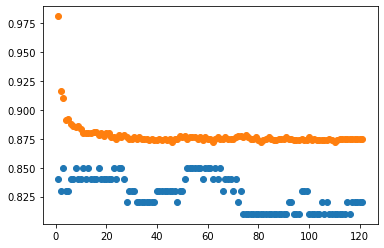

In [60]:
# plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.scatter(list(range(1, 122)), acc_test_list)
# plt.subplot(1, 2, 2) # row 1, col 2 index 1
plt.scatter(list(range(1, 122)), acc_train_list)

Como podemos ver no gráfico em laranja, a medida que diminuimos o número de vizinhos a acurácia sobre os dados de treinamento tende a crescer. Com 3 vizinhos, possuímos o resultado:
* ACC TRAINING: 0.91
* ACC VALID: 0.85

Apesar de diminuirmos o viés, aumentamos a variância em 0.005, pois melhoramos mais sobre os dados de treinamento que sobre os dados de teste. É importante salientar que dependendo do tipo dos dados, se estão mais próximos da amostra de treinamento, ou não, vale a pena investir num dado com viés menor que a variância.

#Bônus (Auto Sklearn)

In [ ]:
from autosklearn.classification import AutoSklearnClassifier
#ASKL (C-Support Vector Classification)
#Construindo o modelo
model =  AutoSklearnClassifier()
model.fit(Xtrain, ytrain)
model.cv_results_
model.sprint_statistics()

In [ ]:
print(model.sprint_statistics())